# Importing Necessary Libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import copy
import pickle
import argparse
import json
from datetime import datetime
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC
import xgboost as xgb
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from collections import Counter
import shap
from tqdm import tqdm
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from collections import OrderedDict
from sklearn.model_selection import GridSearchCV, cross_val_predict
%matplotlib inline

# Reading the DataSet

### Define file Path

In [2]:
data_directory = "/Users/rolex/Desktop/IGP/Project/Data/"
df_train_scaled = 'df_train_scaled.csv.zip'
df_test_scaled = 'df_test_scaled.csv.zip'
df_train_path = os.path.join(data_directory , df_train_scaled)
df_test_path = os.path.join(data_directory , df_test_scaled)

### Read CSV file in chunks

In [3]:
chunk_size = 10000
df_train_chunks = pd.read_csv(df_train_path, index_col=0, compression='zip', chunksize = chunk_size)
df_test_chunks = pd.read_csv(df_test_path, index_col=0, compression='zip', chunksize = chunk_size)

#Concatenate chunks into single DataFrame
df_train = pd.concat(df_train_chunks)
df_test = pd.concat(df_test_chunks)

In [4]:
# Define threshold for binary classification
threshold = 0.5

# Convert loan_status to binary
df_train['loan_status'] = (df_train['loan_status'] > threshold).astype(int)
df_test['loan_status'] = (df_test['loan_status'] > threshold).astype(int)


In [5]:
df_train.shape, df_test.shape

((1073090, 21), (194208, 21))

# Response Variable

In [6]:
target_column = 'loan_status'

#Extracting feature space and target variable
X_train = df_train.drop(columns = target_column)
X_test = df_test.drop(columns = target_column)

y_train = df_train[target_column]
y_test = df_test[target_column]

In [7]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1073090, 20), (194208, 20), (1073090,), (194208,))

# Top-features

In [8]:
k = 20 #no. of best top-features to select

#pipeline with imputation and feature selection
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('selector', SelectKBest(score_func=f_classif, k=k))
])

# Fitting pipeline to training data
pipeline.fit(X_train, y_train)

# Extract p-values and scores
pvalues = pipeline.named_steps['selector'].pvalues_
scores = pipeline.named_steps['selector'].scores_

# Create DataFrame for better visualization
feature_scores = pd.DataFrame({
    'Specs': X_train.columns,
    'pvalue': pvalues,
    'Score': scores
})

# Sort and print the top features
top_features = feature_scores.nlargest(k, 'Score')
print(top_features)

                     Specs         pvalue         Score
3                sub_grade   0.000000e+00  85040.105921
2                    grade   0.000000e+00  81124.312578
1                 int_rate   0.000000e+00  79815.493509
0                     term   0.000000e+00  43421.239487
17   balance_annual_income   0.000000e+00  20533.768543
18          fico_avg_score   0.000000e+00  18917.563100
9                      dti   0.000000e+00  13431.938020
19  installment_amnt_ratio   0.000000e+00   6027.993889
7      verification_status   0.000000e+00   4585.184621
13                mort_acc   0.000000e+00   4327.893116
12              revol_util   0.000000e+00   3310.560083
16       credit_line_ratio   0.000000e+00   3269.616078
6               annual_inc   0.000000e+00   3221.386981
5           home_ownership   0.000000e+00   2426.120497
15          credit_history   0.000000e+00   1621.979205
10                 pub_rec  3.666157e-269   1229.329829
14    pub_rec_bankruptcies  1.512862e-169    770

# Drop Columns

In [9]:
drop_features = ['pub_rec','pub_rec_bankruptcies','emp_length','purpose','revol_bal','grade','int_rate']

# Drop columns from df_train and df_test
df_train = df_train.drop(columns = drop_features)
df_test = df_test.drop(columns = drop_features)

# Reassign X_train and X_test
X_train = df_train.drop(columns = [target_column])
X_test = df_test.drop(columns = [target_column])


print(X_train.shape, X_test.shape) 

(1073090, 13) (194208, 13)


# Dictionaries to store ROC and precision-recall curve data

In [10]:
roc_dict = {}
prc_dict = {}

#function to modify ROC dictionary
def update_roc_dict(clf, y_test, X_test, name, dict_modify):
    """
    Updates a dictionary with ROC metrics for a given classifier.
    """
    fpr, tpr, thresholds = roc_curve(y_test,
                                     clf.predict_proba(X_test)[: , 1],
                                     pos_label = 1)
    clf_roc_dict = {'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds}
    dict_modify[name] = clf_roc_dict

# function to modify precision-recall dictionary
def update_prc_dict(clf, y_test, X_test, name, dict_modify):
    """
    Updates a dictionary with precision-recall metrics for a given classifier.
    """
    precision, recall, thresholds = precision_recall_curve(y_test,
                                     clf.predict_proba(X_test)[: , 1],
                                     pos_label = 1)
    clf_prc_dict = {'precision': precision, 'recall': recall, 'thresholds': thresholds}
    dict_modify[name] = clf_prc_dict

# update_roc_dict(clf, y_test, X_test, 'classifier_name', roc_dict)
# update_prc_dict(clf, y_test, X_test, 'classifier_name', prc_dict)

# Custom function to fit a classifier from scikit-learn that returns a DataFrame containing classification report.

In [11]:
def fit_score_classifier(classifier, X_train, y_train, X_test, y_test, name='classifier'):
    """
    Parameters:
        classifier (sklearn classifier): Classifier object
        X_train (numpy array): Training features
        y_train (numpy array): Training labels
        X_test (numpy array): Test features
        y_test (numpy array): Test labels
        name (string): Name of the classifier
        
    Returns:
        pd.DataFrame: DataFrame containing classification report
    """
    # Fit the classifier to the training data
    classifier.fit(X_train, y_train)
    
    # Make predictions
    y_pred = classifier.predict(X_test)
    
    # Generate classification report
    classifier_report_dict = classification_report(y_test, y_pred, output_dict=True)
    
    # Convert classification report dictionary to DataFrame
    classifier_report = pd.DataFrame.from_dict(classifier_report_dict)
    
    # Add classifier name as a column
    classifier_report['classifier'] = name
    
    return classifier_report

# Logistic Regression

In [12]:
# Instantiate logistic regression with default parameters
lr = LogisticRegression(penalty = 'l2', C = 1.0, solver = 'lbfgs', max_iter = 400, n_jobs = -1)

lr_report = fit_score_classifier(lr, X_train, y_train, X_test, y_test, name = 'lr')
lr_report.head()

,0,1,accuracy,macro avg,weighted avg,classifier
precision,0.732913,0.576291,0.728199,0.654602,0.689624,lr
recall,0.982374,0.062763,0.728199,0.522569,0.728199,lr
f1-score,0.839504,0.113198,0.728199,0.476351,0.638757,lr
support,140530.000000,53678.000000,0.728199,194208.000000,194208.000000,lr


In [13]:
#Metrics for LR
update_roc_dict(clf = lr, y_test = y_test, X_test = X_test, name = 'Logistic Regression', dict_modify = roc_dict)
update_prc_dict(clf = lr, y_test = y_test, X_test = X_test, name = 'Logistic Regression', dict_modify = prc_dict)

# Gradient Boosting

In [14]:
#Instaniate GBoost Classifier
gb = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 100)

#fit_score_classifier function to fit and score the GradientBoostingClassifier
gb_report = fit_score_classifier(gb, X_train, y_train, X_test, y_test, name = 'gb')
gb_report.head()

,0,1,accuracy,macro avg,weighted avg,classifier
precision,0.732122,0.600000,0.728734,0.666061,0.695604,gb
recall,0.985825,0.055665,0.728734,0.520745,0.728734,gb
f1-score,0.840240,0.101879,0.728734,0.471060,0.636161,gb
support,140530.000000,53678.000000,0.728734,194208.000000,194208.000000,gb


In [15]:
# Modify ROC and precision-recall curve dictionaries for GBTree
update_roc_dict(clf = gb , y_test = y_test, X_test = X_test, name='GB', dict_modify = roc_dict)
update_prc_dict(clf = gb , y_test = y_test, X_test = X_test, name='GB', dict_modify = prc_dict)

# Random Forest Classifier.

In [16]:
#Instaniate RandomForest Classifier
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

#function to fit and score the random forest classifier
rf_report = fit_score_classifier(rf, X_train, y_train, X_test, y_test, name='rf')
rf_report.head()

,0,1,accuracy,macro avg,weighted avg,classifier
precision,0.737016,0.563966,0.729306,0.650491,0.689186,rf
recall,0.973152,0.090912,0.729306,0.532032,0.729306,rf
f1-score,0.838781,0.156583,0.729306,0.497682,0.650226,rf
support,140530.000000,53678.000000,0.729306,194208.000000,194208.000000,rf


In [17]:
# Modify ROC and precision-recall curve dictionaries for RFClassifier
update_roc_dict(clf = rf , y_test = y_test, X_test = X_test, name='RandomForest', dict_modify = roc_dict)
update_prc_dict(clf = rf , y_test = y_test, X_test = X_test, name='RandomForest', dict_modify = prc_dict)

# XGBoost Classifier

In [18]:
#Instaniate XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(n_estimators=300, subsample=0.9, n_jobs=-1)

#function to fit and score the XGBoost classifier
xgb_report = fit_score_classifier(xgb_classifier, X_train, y_train, X_test, y_test, name='xgb')
xgb_report.head()

,0,1,accuracy,macro avg,weighted avg,classifier
precision,0.740105,0.560804,0.730274,0.650455,0.690547,xgb
recall,0.966719,0.111256,0.730274,0.538987,0.730274,xgb
f1-score,0.838368,0.185676,0.730274,0.512022,0.657968,xgb
support,140530.000000,53678.000000,0.730274,194208.000000,194208.000000,xgb


In [19]:
# Modify ROC and precision-recall curve dictionaries for RFClassifier
update_roc_dict(clf = xgb_classifier , y_test = y_test, X_test = X_test, name='XGBoost', dict_modify = roc_dict)
update_prc_dict(clf = xgb_classifier , y_test = y_test, X_test = X_test, name='XGBoost', dict_modify = prc_dict)

In [20]:
print("Feature Importances:", xgb_classifier.feature_importances_)
print("Classes:", xgb_classifier.classes_)

Feature Importances: [0.10927077 0.44272777 0.05488997 0.0323217  0.03542374 0.04957719
 0.03126478 0.04299391 0.03011177 0.03477827 0.04476326 0.0459623
 0.04591458]
Classes: [0 1]


# Support Vector Classifier

In [21]:
# Instantiate the SVC classifier with a hard limit on iterations
svc_pipeline = make_pipeline(StandardScaler(), SVC(C=1.0, kernel='rbf', gamma='auto', probability=True, max_iter=400))
    
#function to fit and score the SVC classifier
svc_report = fit_score_classifier(svc_pipeline, X_train, y_train, X_test, y_test, name='svc')
svc_report.head()

Solver terminated early (max_iter=400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


,0,1,accuracy,macro avg,weighted avg,classifier
precision,0.721891,0.257365,0.683489,0.489628,0.593499,svc
recall,0.915157,0.076978,0.683489,0.496067,0.683489,svc
f1-score,0.807116,0.118509,0.683489,0.462812,0.616789,svc
support,140530.000000,53678.000000,0.683489,194208.000000,194208.000000,svc


In [22]:
# Modify ROC and precision-recall curve dictionaries for Support Vector Classifier
update_roc_dict(clf = svc_pipeline , y_test = y_test, X_test = X_test, name='SVC', dict_modify = roc_dict)
update_prc_dict(clf = svc_pipeline , y_test = y_test, X_test = X_test, name='SVC', dict_modify = prc_dict)

# KNearestNeighbors Classifier

In [23]:
# Instantiate the KNN classifier 
knn = KNeighborsClassifier(n_neighbors = 5, n_jobs = -1)

#function to fit and score the KNN classifier
knn_report = fit_score_classifier(knn, X_train, y_train, X_test, y_test, name='KNN')
knn_report.head()

,0,1,accuracy,macro avg,weighted avg,classifier
precision,0.742678,0.444647,0.712334,0.593662,0.660304,KNN
recall,0.921860,0.163791,0.712334,0.542826,0.712334,KNN
f1-score,0.822625,0.239398,0.712334,0.531011,0.661424,KNN
support,140530.000000,53678.000000,0.712334,194208.000000,194208.000000,KNN


In [24]:
# Modify ROC and precision-recall curve dictionaries for KNearestNeighbors Classifier
update_roc_dict(clf = knn , y_test = y_test, X_test = X_test, name='KNN', dict_modify = roc_dict)
update_prc_dict(clf = knn , y_test = y_test, X_test = X_test, name='KNN', dict_modify = prc_dict)

# Check Keys

In [25]:
roc_dict.keys()

dict_keys(['Logistic Regression', 'GB', 'RandomForest', 'XGBoost', 'SVC', 'KNN'])

# Plot Models

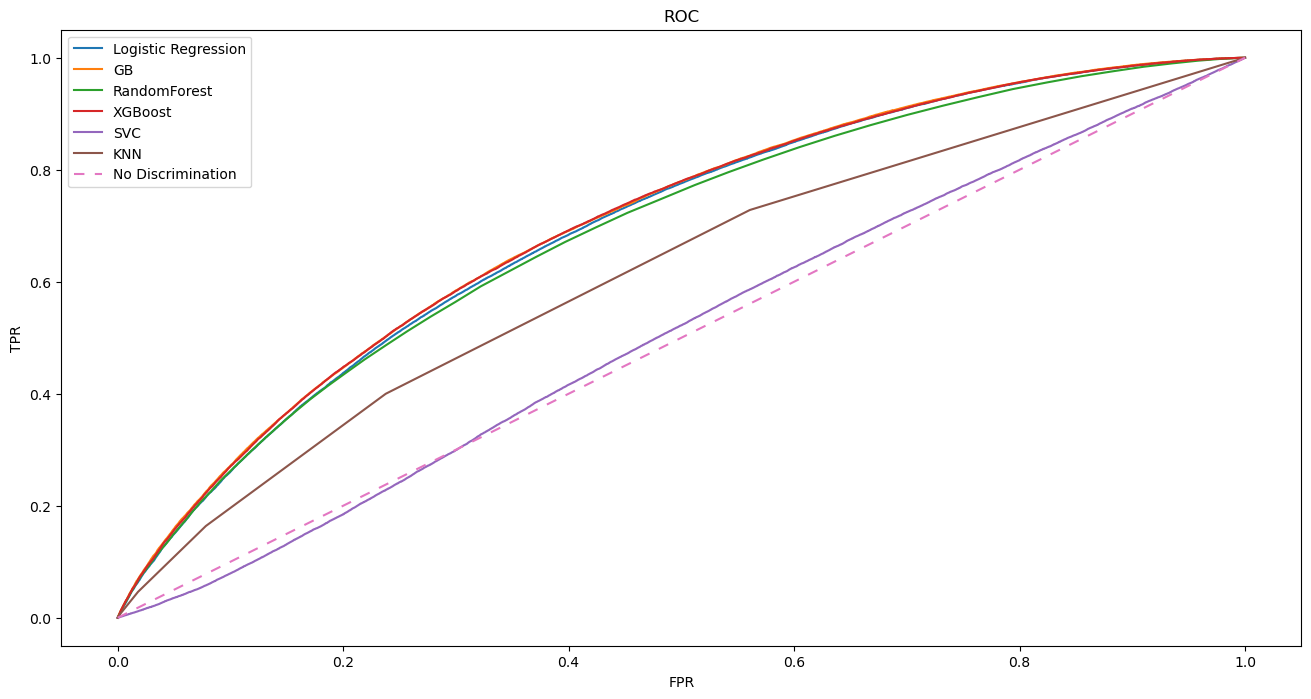

In [26]:
#ROC Curve
plt.figure(figsize=(16, 8))

# Iterate over keys and values in roc_dict
for key, clf in roc_dict.items():
    plt.plot(clf['fpr'], clf['tpr'], label=key)

# Plot settings
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.plot([0,1], [0,1], label='No Discrimination', linestyle='-', dashes=(5, 5))
plt.legend()

# Save and display the plot
plt.savefig(os.path.join("/Users/rolex/Desktop/IGP/Project/plots/roc_curve_indv_models.png"))
plt.legend()
plt.show()


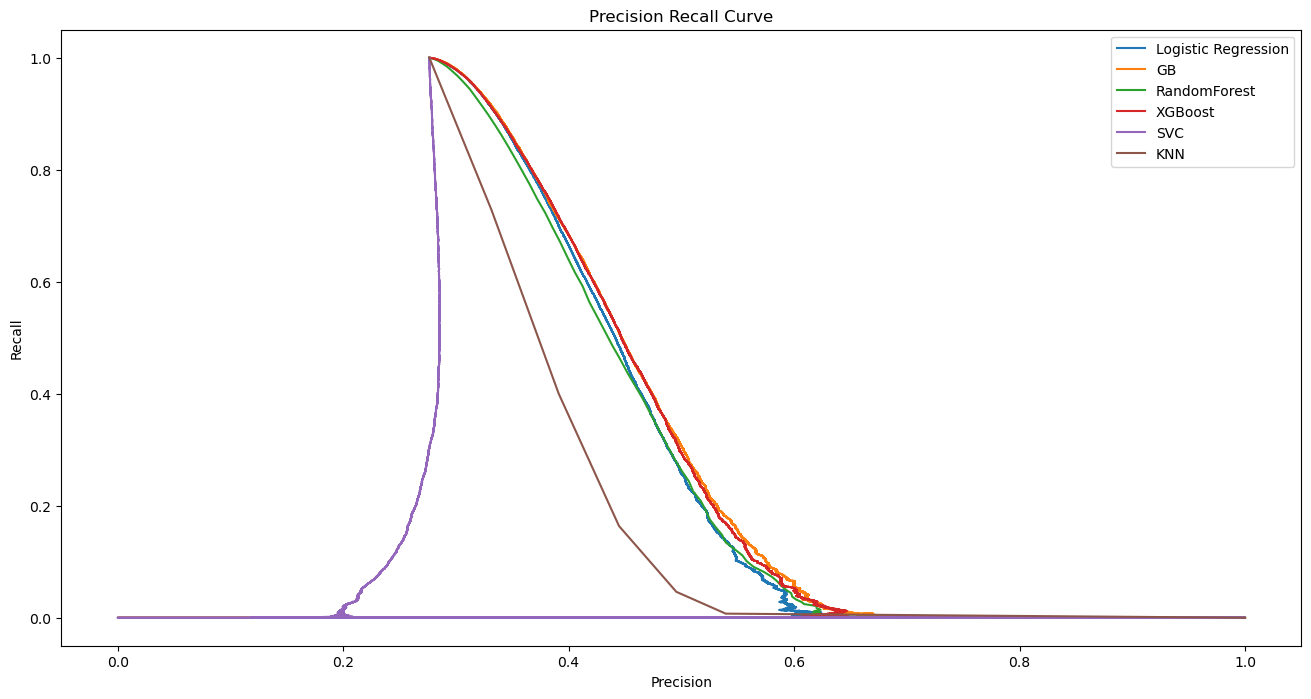

In [27]:
#Precision Recall Curve
plt.figure(figsize=(16, 8))

# Iterate over keys and values in prc_dict
for key, clf in prc_dict.items():
    plt.plot(clf['precision'], clf['recall'], label=key)

# Plot settings
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision Recall Curve")
plt.legend()

# Save and display the plot
plt.savefig(os.path.join("/Users/rolex/Desktop/IGP/Project/plots/prc_curve_indv_models.png"))
plt.legend()
plt.show()

# Calculate the class imbalance ratio

In [28]:
# Calculate class imbalance ratio
class_counts = Counter(y_train)
imbalance_ratio = class_counts[0] / class_counts[1]

print('Imbalance class ratio: %.3f' % imbalance_ratio)

# Instantiate XGBoost Classifier with scale_pos_weight
xgb_classifier = xgb.XGBClassifier(
    n_estimators=300,
    subsample=0.9,
    n_jobs=-1,
    scale_pos_weight=imbalance_ratio,
    base_score=0.5,
    booster='gbtree',
    colsample_bylevel=1,
    colsample_bynode=1,
    colsample_bytree=1,
    gamma=0,
    importance_type='gain',
    interaction_constraints='',
    learning_rate=0.3,
    max_delta_step=0,
    max_depth=6,
    min_child_weight=1,
    monotone_constraints='()',
    num_parallel_tree=1,
    objective='binary:logistic',
    random_state=0,
    reg_alpha=0,
    reg_lambda=1,
    tree_method='exact'
)
# Fit the XGBoost classifier to the data
xgb_classifier.fit(X_train, y_train)


Imbalance class ratio: 3.973


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=0, max_depth=6,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints='()', multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_parallel_tree=1, random_state=0, ...)

# Store trained model for deployment

In [29]:
#directory to save the trained model
save_model_dir = "/Users/rolex/Desktop/IGP/Project/models/xgb_default_params.pkl"
print("Saving model at:", save_model_dir)

# Save the model
with open(save_model_dir, 'wb') as file:
    pickle.dump(gb, file, protocol=pickle.HIGHEST_PROTOCOL)

Saving model at: /Users/rolex/Desktop/IGP/Project/models/xgb_default_params.pkl


# Weighted Importance ("Weight" refers to how frequently a feature occurs inside a tree)

<Figure size 1600x800 with 0 Axes>

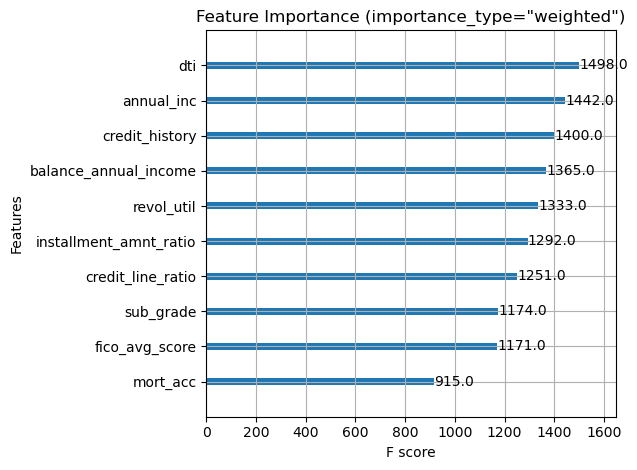

In [30]:
# importance type and max number of features
importance_type = 'weight'
max_num_features = 10

# Plotting feature importance 
plt.figure(figsize=(16, 8))
xgb.plot_importance(xgb_classifier, 
                    importance_type=importance_type,
                    max_num_features=max_num_features, 
                    title='Feature Importance (importance_type="weighted")')
plt.tight_layout()
plt.show()

# Gain importance (The average gain of splits using the feature is referred to as "gain")

<Figure size 1600x800 with 0 Axes>

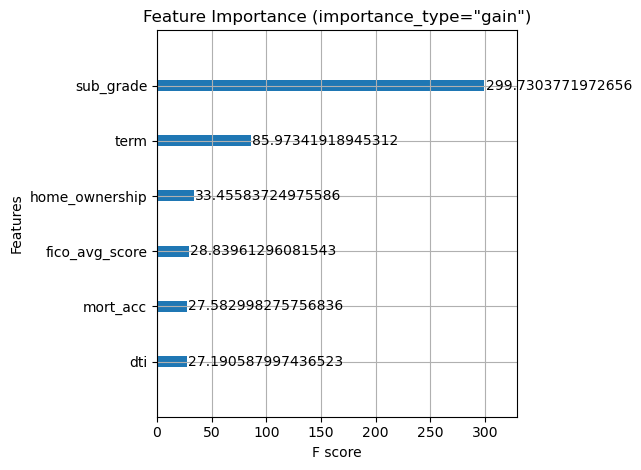

In [31]:
# importance type and max number of features
importance_type = 'gain'
max_num_features = 6

# Plotting feature importance 
plt.figure(figsize=(16, 8))
xgb.plot_importance(xgb_classifier, 
                    importance_type=importance_type,
                    max_num_features=max_num_features, 
                    title='Feature Importance (importance_type="gain")')
plt.tight_layout()
plt.show()


# Cover ("cover" denotes the mean coverage of splits utilizing the feature)

<Figure size 1600x800 with 0 Axes>

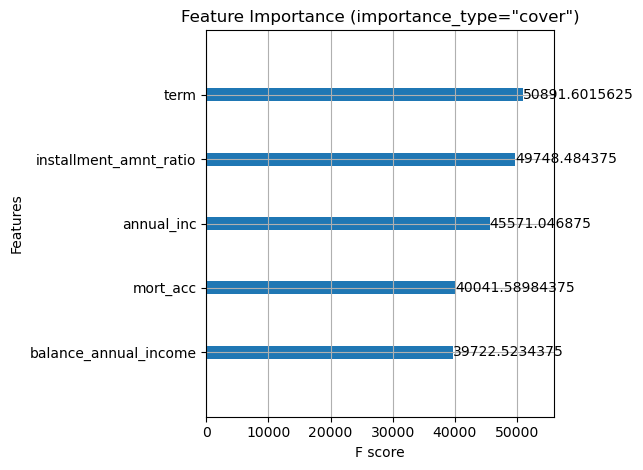

In [32]:
# importance type and max number of features
importance_type = 'cover'
max_num_features = 5

# Plotting feature importance 
plt.figure(figsize=(16, 8))
xgb.plot_importance(xgb_classifier, 
                    importance_type=importance_type,
                    max_num_features=max_num_features, 
                    title='Feature Importance (importance_type="cover")')
plt.tight_layout()
plt.show()


# Predicting labels and probabilities

In [33]:
y_pred = xgb_classifier.predict(X_test)
y_prob = xgb_classifier.predict_proba(X_test)[:, 1]  #Extracting probabilities for positive outcomes

# Confusion Matrix & Classification report.

In [34]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Printing classification report
class_report = metrics.classification_report(y_test, y_pred)
print(class_report)

[[91095 49435]
 [19296 34382]]
              precision    recall  f1-score   support

           0       0.83      0.65      0.73    140530
           1       0.41      0.64      0.50     53678

    accuracy                           0.65    194208
   macro avg       0.62      0.64      0.61    194208
weighted avg       0.71      0.65      0.66    194208



# AUC Score

In [35]:
area_under_curve = roc_auc_score(y_test, y_prob)
print('AUC: %.3f' % area_under_curve)

AUC: 0.699


# Fico vs Sub-Grade

In [36]:
df_grade_fico = pd.read_csv('/Users/rolex/Desktop/IGP/Project/Data/sub_grade_fico.csv')
df_grade_fico.head()

,sub_grade,score,value
0,A1,789,34
1,A2,780,33
2,A3,769,32
3,A4,761,31
4,A5,741,30


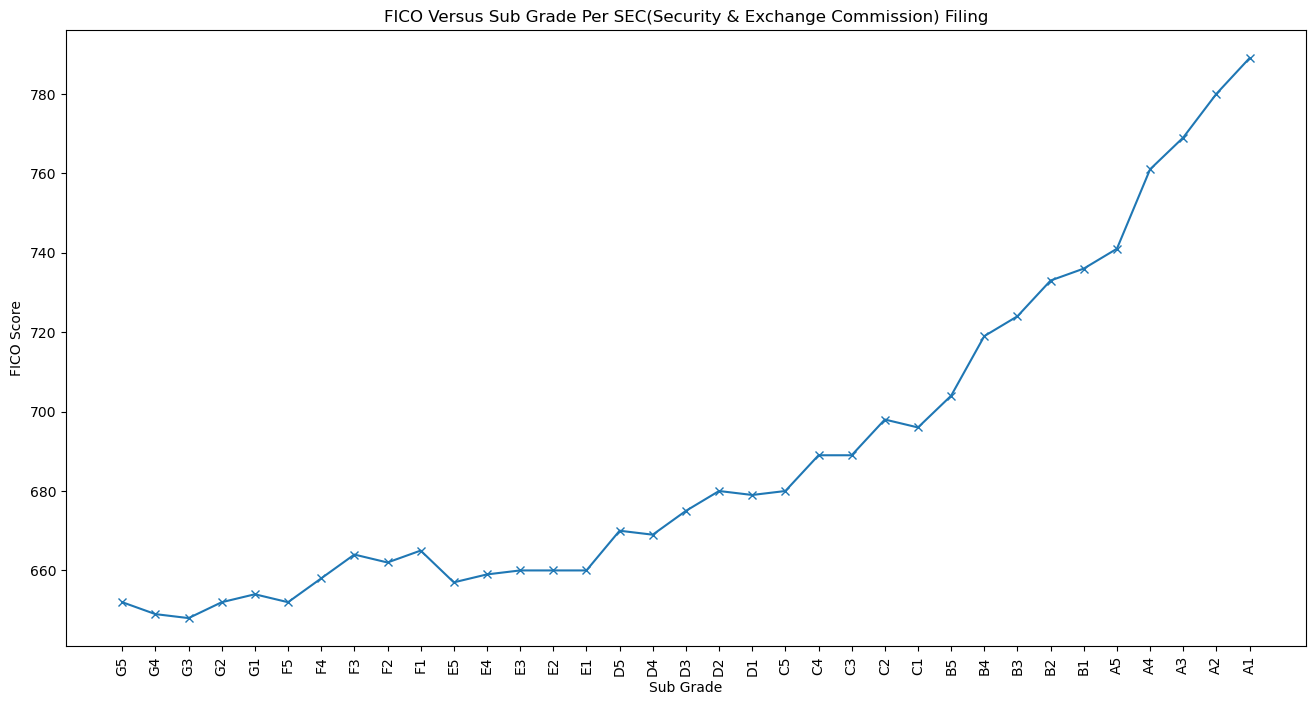

In [37]:
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the data
ax.plot(df_grade_fico['value'], df_grade_fico['score '], marker='x')

# ticks and labels for x-axis
ax.set_xticks(range(df_grade_fico.shape[0]))
ax.set_xticklabels(df_grade_fico['sub_grade'][::-1], rotation='vertical')

# labels and title
ax.set_xlabel('Sub Grade')
ax.set_ylabel('FICO Score')
ax.set_title('FICO Versus Sub Grade Per SEC(Security & Exchange Commission) Filing')

# Save and display the plot
plt.savefig('/Users/rolex/Desktop/IGP/Project/plots/fico_grade_line.png')
plt.show()

# KNearestNeighbors Regressor

In [38]:
# Instantiate KNN regressor
knn = KNeighborsRegressor(n_neighbors=1)

# Fitting the model to data
X = df_grade_fico['score '].values.reshape(-1, 1)
y = df_grade_fico['value']
knn.fit(X, y)

# sample prediction
sample_score = 750
sample_prediction = knn.predict([[sample_score]])[0]

# Print the prediction
print("Prediction for FICO score {}: {}".format(sample_score, sample_prediction))


Prediction for FICO score 750: 30.0


## Save the KNN Regression model

In [39]:
model_path = os.path.join('/Users/rolex/Desktop/IGP/Project/models/knn_regression.pkl')
with open(model_path, 'wb') as file:
    pickle.dump(knn, file)

# Sub-Grade to Annual Percentage Rate(APR)

In [40]:
df_apr = pd.read_csv('/Users/rolex/Desktop/IGP/Project/Data/sub_grade_apr.csv')
df_apr.head()

,grade_num,loan_grade,apr,36_mo,60_mo
0,34,A1,6.03,6.78,7.30
1,33,A2,6.97,7.99,8.26
2,32,A3,7.62,8.99,8.91
3,31,A4,8.60,9.98,9.91
4,30,A5,9.25,10.99,10.56


The formula to calculate APR is:

    APR = (((Fees + Interest/Principal)/ n) * 365) * 100


In [41]:
df_apr.loc[df_apr['grade_num'] == 30, '36_mo']

4    10.99
Name: 36_mo, dtype: float64

# Class Occurences & Confusion Matrix

In [42]:
# Count class occurrences in the training set
class_counter = Counter(y_train)

# Calculate the scale_pos_weight value
scale_pos_weight_value = class_counter[0] / class_counter[1]
print('Scale_pos_weight value: %.3f' % scale_pos_weight_value)

# Instantiate XGBoost classifier with specified parameters
xgb_classifier = XGBClassifier(n_estimators=300,
                    subsample=0.9,
                    n_jobs=-1,
                    scale_pos_weight=scale_pos_weight_value)

# Fit the classifier to the training data
xgb_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_classifier.predict(X_test)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', conf_matrix)

Scale_pos_weight value: 3.973
Confusion Matrix:
 [[91010 49520]
 [19256 34422]]


## Probabilities for the positive class

In [43]:
y_pred_prob = xgb_classifier.predict_proba(X_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

# Cross-Validation Prediction

In [44]:
y_scores = cross_val_predict(xgb_classifier, X_test, y_test, cv=5, method='predict_proba')

# Extract positive class probabilities
y_scores_pos = y_scores[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores_pos, pos_label=1)


# ROC Curve for XGB

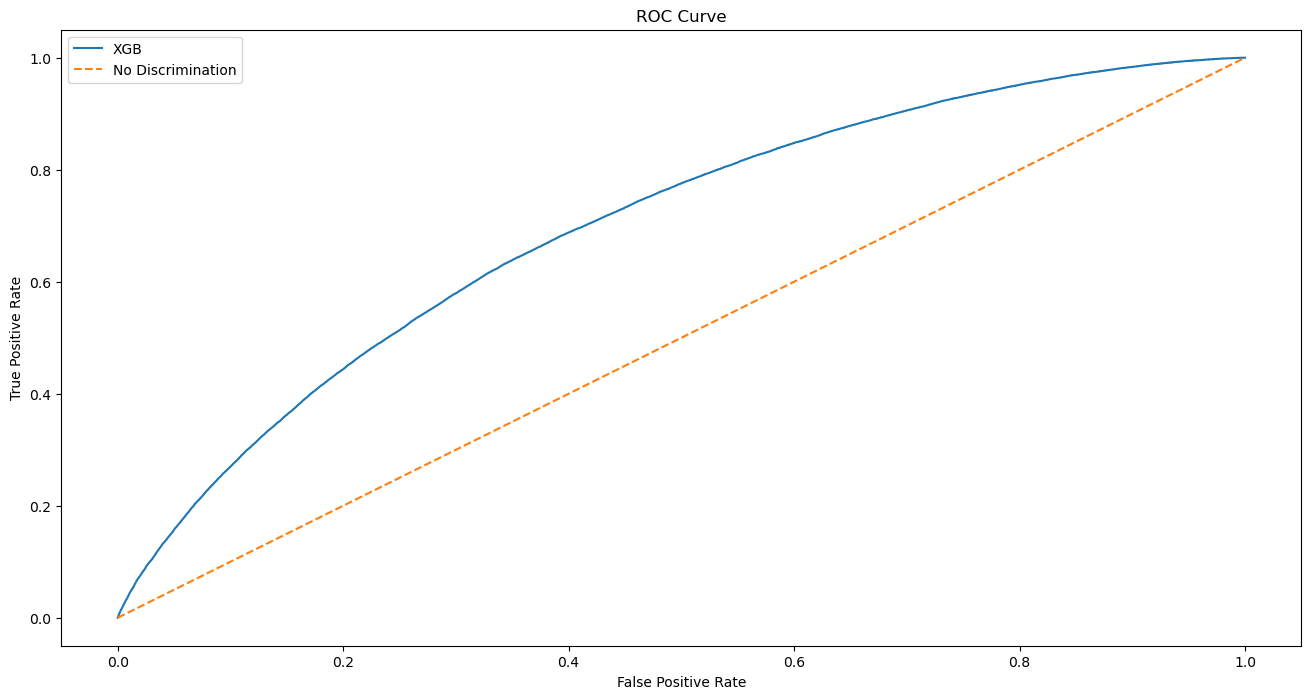

In [45]:
# Set the figure size
plt.figure(figsize=(16, 8))

# Plot the ROC curve for XGB
plt.plot(fpr, tpr, label='XGB')

# Plot the line of no discrimination
plt.plot([0, 1], [0, 1], label='No Discrimination', linestyle='--')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.show()

# Predicted Probability for the positive class

In [46]:
y_pred_prob_pos = xgb_classifier.predict_proba(X_test)[:, 1]

# ROC AUC score
xgb_auc = roc_auc_score(y_test, y_pred_prob_pos)

print("xgb_auc: {}".format(xgb_auc))

xgb_auc: 0.6978593125601882


# Predictions on test data

In [47]:
y_pred_xgb = xgb_classifier.predict(X_test)

#F1 score
f1_xgb = f1_score(y_test, y_pred_xgb)
print("f1_xgb (binary): {}\n".format(f1_xgb))

# classification report
print(classification_report(y_test, y_pred_xgb))


f1_xgb (binary): 0.5002470571137916

              precision    recall  f1-score   support

           0       0.83      0.65      0.73    140530
           1       0.41      0.64      0.50     53678

    accuracy                           0.65    194208
   macro avg       0.62      0.64      0.61    194208
weighted avg       0.71      0.65      0.66    194208



# Store trained model

In [48]:
#directory to save the trained model
save_model_dir = "/Users/rolex/Desktop/IGP/Project/models/xgb_cv.pkl"
print("Saving model at:", save_model_dir)

# Save the model
with open(save_model_dir, 'wb') as file:
    pickle.dump(gb, file, protocol=pickle.HIGHEST_PROTOCOL)

Saving model at: /Users/rolex/Desktop/IGP/Project/models/xgb_cv.pkl


# Input Data

In [49]:
#get input
fico = 800
loan_amnt = 1200
term = '60 months'
dti = 2
home_ownership = 'rent'
mort_acc = 5
annual_inc = 50_000
open_acc = 5
employment = 'nurse'
verification_status = 1
revol_util = 60
application_type = 0
total_acc=1

In [50]:
# Calculate sub_grade from FICO
fico_score = 800
sub_grade = knn.predict(np.array(fico_score).reshape(1, -1))[0]

# Calculate grade
grade = (sub_grade // 5) + 1

# Get interest rate
apr_roi = df_apr[df_apr['grade_num'] == sub_grade]

In [51]:
apr_roi

,grade_num,loan_grade,apr,36_mo,60_mo
0,34,A1,6.03,6.78,7.3


# Determine term & calculate interest rate and installment

In [52]:
if term == '36 months':
    int_rate_col = '36_mo'
    term_months = 36
else:
    int_rate_col = '60_mo'
    term_months = 60

int_rate = apr_roi[int_rate_col].values[0]
installment = float(loan_amnt) / term_months

In [53]:
term_map = {'36 months': 1, '60 months': 2}
home_map = {'MORTGAGE': 4, 'RENT': 3, 'OWN': 5,'ANY': 2,'OTHER': 1, 'NONE':0 }

In [54]:
X_train.columns

Index(['term', 'sub_grade', 'home_ownership', 'annual_inc',
       'verification_status', 'dti', 'revol_util', 'mort_acc',
       'credit_history', 'credit_line_ratio', 'balance_annual_income',
       'fico_avg_score', 'installment_amnt_ratio'],
      dtype='object')

In [55]:
feature_to_list=['term','sub_grade','home_ownership', 'annual_inc', 'verification_status',
       'dti','revol_util', 'mort_acc','credit_hist', 'credit_line_ratio',
       'balance_annual_inc', 'fico_avg_score', 'inst_amnt_ratio']

## Data dictionary

In [56]:
data = {
    'term': term_map[term],
    'sub_grade': sub_grade,
    'home_ownership': home_map[home_ownership.upper()],
    'annual_inc': np.log(annual_inc),
    'verification_status': verification_status,
    'dti': dti,
    'revol_util': revol_util,
    'mort_acc': mort_acc,
    'credit_history': 20,
    'credit_line_ratio': open_acc / total_acc,
    'balance_annual_income': loan_amnt / annual_inc,
    'fico_avg_score': fico,
    'installment_amnt_ratio': installment / loan_amnt
}

temp = pd.DataFrame(data, index=[1])

In [57]:
temp

,term,sub_grade,home_ownership,annual_inc,verification_status,dti,revol_util,mort_acc,credit_history,credit_line_ratio,balance_annual_income,fico_avg_score,installment_amnt_ratio
1,2,34.0,3,10.819778,1,2,60,5,20,5.0,0.024,800,0.016667


In [58]:
# File paths
file_paths = ["/Users/rolex/Desktop/IGP/Project/Data/df_macro_mean.csv", "/Users/rolex/Desktop/IGP/Project/Data/df_macro_std.csv"]

df_macro_mean = pd.read_csv(file_paths[0], index_col=0)
df_macro_std = pd.read_csv(file_paths[1], index_col=0)

In [59]:
# Columns to drop
columns = ['emp_length', 'purpose', 'revol_bal', 'grade', 'int_rate']

# Drop columns from the combined DataFrame
df_macro_mean = df_macro_mean.drop(columns=columns)
df_macro_std = df_macro_std.drop(columns=columns)

In [60]:
scale = temp.copy()

code = 70

# Iterate over each feature in df_macro_mean.columns
for feat in df_macro_mean.columns:
    # Calculate the scaled value for each feature
    scale[feat] = (scale[feat] - df_macro_mean.loc[code, feat]) / df_macro_std.loc[code, feat]

scale.head()

,term,sub_grade,home_ownership,annual_inc,verification_status,dti,revol_util,mort_acc,credit_history,credit_line_ratio,balance_annual_income,fico_avg_score,installment_amnt_ratio
1,1.661923,1.650263,-1.379619,-0.560838,-0.121252,-2.020499,0.281008,1.695813,-2.221532,26.330898,-1.683967,3.192017,-3.276675


In [61]:
xgb_classifier.predict(scale)[0]

0

# Model Tuning

In [62]:
data_directory = "/Users/rolex/Desktop/IGP/Project/Data/"
df_train_scaled = 'df_train_scaled.csv.zip'
df_test_scaled = 'df_test_scaled.csv.zip'
df_train_path = os.path.join(data_directory , df_train_scaled)
df_test_path = os.path.join(data_directory , df_test_scaled)

In [63]:
df_train_scaled = pd.read_csv(df_train_path)
df_train_scaled.head()

,Unnamed: 0,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,...,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies,credit_history,credit_line_ratio,balance_annual_income,fico_avg_score,installment_amnt_ratio
0,0,-0.608872,0.164693,-0.163457,-0.325463,1.122052,0.447071,-0.429185,-1.307963,0,...,0,-0.546784,-1.023435,-0.312566,0,-0.507738,0.163442,-1.289327,-0.664438,0.751798
1,67,1.642269,1.571844,-1.681827,-1.852288,-1.097898,2.003534,0.922524,-1.307963,1,...,0,0.051569,1.656392,0.185487,0,1.811497,-0.290346,0.013519,-1.142713,-0.953725
2,109,-0.608872,0.164693,-0.163457,-0.325463,-1.097898,-1.109391,0.373296,1.107810,0,...,0,-0.039984,1.171393,-0.810619,0,-0.405765,-0.661155,-1.119129,-0.505013,0.751305
3,166,-0.608872,0.045809,-0.163457,-0.172780,-1.375392,-1.109391,-1.966736,1.107810,0,...,0,-0.491274,-0.982334,-0.810619,0,-1.030678,0.453866,-0.581365,0.451536,0.690353
4,240,-0.608872,0.350584,-0.163457,-0.478145,-1.097898,-1.109391,-0.044315,1.107810,0,...,0,-0.101400,0.123301,-0.810619,0,0.015201,-0.203410,-1.206653,-0.823863,0.847883


## Hyper Parameter tuning (Class Distribution)

In [64]:
class_distribution = Counter(y_train)
positive_class_count = class_distribution[1]
negative_class_count = class_distribution[0]

# Estimate scale_pos_weight value
scale_pos_weight_estimate = negative_class_count / positive_class_count
print('Estimate: %.3f' % scale_pos_weight_estimate)

# parameter grid
param_grid = {
    'xgb__eta': [0.05, 0.1, 0.3],
    'xgb__max_depth': [3, 6, 12],
    'xgb__colsample_bytree': [0.9, 1.0],
}

# pipeline
model_pipeline = Pipeline([
    ('xgb', xgb.XGBClassifier(n_estimators=200, n_jobs=-1, scale_pos_weight=scale_pos_weight_estimate))
])

# classifier
classifier = GridSearchCV(
    model_pipeline,
    param_grid,
    n_jobs=-1,
    cv=3,
    verbose=50,
    scoring='roc_auc'
)

# Fit the classifier to the training data
classifier.fit(X_train, y_train)

Estimate: 3.973
Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      interaction_constraints=N...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=200,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgb__colsample_bytree': [0.9, 1.0],
                         'xgb__eta': [0.05, 0.1, 0.3],
                         'xgb__max_depth': [3, 6, 12]},
             scoring='roc_auc', verbose=50)

In [65]:
# best parameters from GridSearchCV object
best_params = classifier.best_params_
print("Best model parameters: \n", best_params)

# best score from GridSearchCV object
best_score = classifier.best_score_
print("Best model score: \n", best_score)

Best model parameters: 
 {'xgb__colsample_bytree': 0.9, 'xgb__eta': 0.05, 'xgb__max_depth': 6}
Best model score: 
 0.7155497784821289


In [66]:
# predictions on the test set
y_pred = classifier.predict(X_test)

# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[90077 50453]
 [18338 35340]]


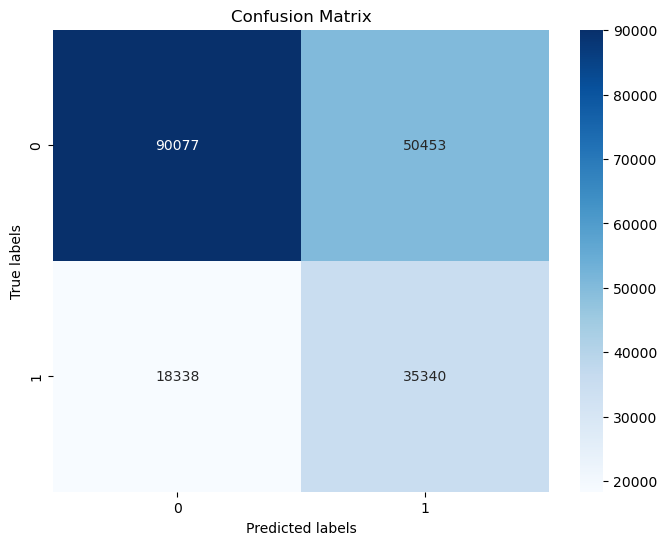

In [67]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### predicted probabilities for the positive class

In [68]:
y_prob_positive_class = xgb_classifier.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_positive_class, pos_label=1)

### ROC Curve

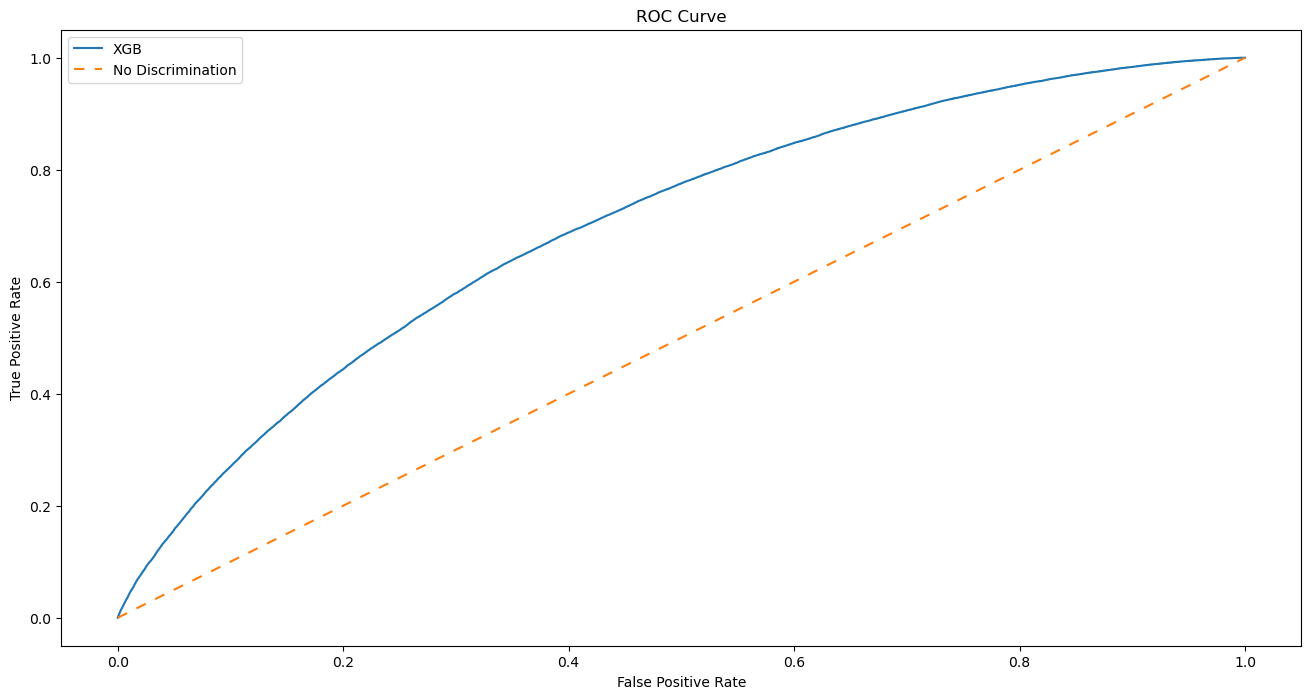

AUC: 0.698


In [69]:
plt.figure(figsize=(16, 8))
plt.plot(fpr, tpr, label='XGB')
plt.plot([0, 1], [0, 1], label='No Discrimination', linestyle='-', dashes=(5, 5))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Calculate AUC
auc_alternate = roc_auc_score(y_test, xgb_classifier.predict_proba(X_test)[:, 1])
print('AUC: %.3f' % auc_alternate)

### F1-Score

In [70]:
# F1 score
f1 = f1_score(y_test, y_pred)

# Print F1 score
print("F1 score (binary): {}\n".format(f1))

# Print classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

F1 score (binary): 0.506772017121839

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.64      0.72    140530
           1       0.41      0.66      0.51     53678

    accuracy                           0.65    194208
   macro avg       0.62      0.65      0.62    194208
weighted avg       0.72      0.65      0.66    194208



# Store model for deployment

In [71]:
#directory to save the trained model
save_model_dir = "/Users/rolex/Desktop/IGP/Project/models/xgb_cv_final.pkl"
print("Saving model at:", save_model_dir)

# Save the model
with open(save_model_dir, 'wb') as file:
    pickle.dump(gb, file, protocol=pickle.HIGHEST_PROTOCOL)

Saving model at: /Users/rolex/Desktop/IGP/Project/models/xgb_cv_final.pkl


# Confidence Interval

In [72]:
data_directory = "/Users/rolex/Desktop/IGP/Project/Data/"
df_train_scaled = 'df_train_scaled.csv.zip'
df_test_scaled = 'df_test_scaled.csv.zip'
df_train_path = os.path.join(data_directory , df_train_scaled)
df_test_path = os.path.join(data_directory , df_test_scaled)

In [73]:
df_train_scaled = pd.read_csv(df_train_path)
df_train_scaled.head()

,Unnamed: 0,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,...,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies,credit_history,credit_line_ratio,balance_annual_income,fico_avg_score,installment_amnt_ratio
0,0,-0.608872,0.164693,-0.163457,-0.325463,1.122052,0.447071,-0.429185,-1.307963,0,...,0,-0.546784,-1.023435,-0.312566,0,-0.507738,0.163442,-1.289327,-0.664438,0.751798
1,67,1.642269,1.571844,-1.681827,-1.852288,-1.097898,2.003534,0.922524,-1.307963,1,...,0,0.051569,1.656392,0.185487,0,1.811497,-0.290346,0.013519,-1.142713,-0.953725
2,109,-0.608872,0.164693,-0.163457,-0.325463,-1.097898,-1.109391,0.373296,1.107810,0,...,0,-0.039984,1.171393,-0.810619,0,-0.405765,-0.661155,-1.119129,-0.505013,0.751305
3,166,-0.608872,0.045809,-0.163457,-0.172780,-1.375392,-1.109391,-1.966736,1.107810,0,...,0,-0.491274,-0.982334,-0.810619,0,-1.030678,0.453866,-0.581365,0.451536,0.690353
4,240,-0.608872,0.350584,-0.163457,-0.478145,-1.097898,-1.109391,-0.044315,1.107810,0,...,0,-0.101400,0.123301,-0.810619,0,0.015201,-0.203410,-1.206653,-0.823863,0.847883


In [74]:
target_column = 'loan_status'

#Extracting feature space and target variable
X_train = df_train_scaled.drop(columns = target_column)
y_train = df_train_scaled[target_column]

drop_columns=['pub_rec','pub_rec_bankruptcies','emp_length','purpose','revol_bal','grade','int_rate']
X_train=X_train.drop(columns=drop_columns)


In [75]:
df_test_scaled = pd.read_csv(df_test_path)
df_test_scaled.head()

,Unnamed: 0,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,...,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies,credit_history,credit_line_ratio,balance_annual_income,fico_avg_score,installment_amnt_ratio
0,0,-0.570708,-1.292197,1.358839,1.211831,0.854755,-0.987969,-0.548759,1.121379,0,...,0,-0.837022,-2.334517,0.974724,0,0.604761,-1.478367,-1.421052,2.231901,-0.038992
1,78,-0.570708,-0.277482,0.593949,0.285325,1.130541,0.689838,-0.196528,-1.307721,0,...,0,0.907334,0.472810,0.527530,0,0.558767,-0.287923,-0.493957,0.551974,0.480381
2,83,-0.570708,-0.835138,0.593949,0.902995,1.130541,0.689838,1.286175,1.121379,0,...,0,0.232658,-0.556269,0.974724,0,0.943588,0.338626,0.869687,0.887959,0.192246
3,123,-0.570708,2.322725,-1.700719,-1.567686,1.130541,-0.987969,0.760771,-1.307721,0,...,1,-0.660958,-0.350453,0.080337,1,0.313079,-1.384385,-1.711448,-0.959961,1.905790
4,144,1.752125,-0.277482,0.593949,0.285325,-0.524176,0.689838,-0.262192,-1.307721,1,...,0,-0.559868,-1.540069,0.080337,0,-0.176380,0.338626,0.799203,2.231901,-2.143249


In [76]:
target_column = 'loan_status'

#Extracting feature space and target variable
X_test = df_train_scaled.drop(columns = target_column)
y_test = df_train_scaled[target_column]

drop_columns=['pub_rec','pub_rec_bankruptcies','emp_length','purpose','revol_bal','grade','int_rate']
X_test = X_test.drop(columns=drop_columns)

In [77]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()

In [81]:
unnamed_index = df_train_scaled.columns.get_loc('Unnamed: 0')

# Drop the 'Unnamed: 0' column from both X_train and X_test
X_train = np.delete(X_train, unnamed_index, axis=1)
X_test = np.delete(X_test, unnamed_index, axis=1)
y_prob_positive_class = xgb_classifier.predict_proba(X_test)[:, 1]

# Calculate true positives, false positives, true negatives, and false negatives
y_pred_binary = np.where(y_prob_positive_class > 0.5, 1, 0)
true_positives = np.sum((y_pred_binary == 1) & (y_test == 1))
false_positives = np.sum((y_pred_binary == 1) & (y_test == 0))
true_negatives = np.sum((y_pred_binary == 0) & (y_test == 0))
false_negatives = np.sum((y_pred_binary == 0) & (y_test == 1))

# Calculate sensitivity, specificity, precision, and accuracy
sensitivity = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
accuracy = (true_positives + true_negatives) / len(y_test)

# Print the metrics
print("Sensitivity (True Positive Rate):", sensitivity)
print("Specificity (True Negative Rate):", specificity)
print("Precision (Positive Predictive Value):", precision)
print("Accuracy:", accuracy)

# Calculate AUC Score
auc_score = roc_auc_score(y_test, y_prob_positive_class)
print("AUC Score:", auc_score)
classification_rep = classification_report(y_test, y_pred_binary)

# Print the classification report
print("Classification Report:\n", classification_rep)

Sensitivity (True Positive Rate): 0.7179465791766297
Specificity (True Negative Rate): 0.6761297757828703
Precision (Positive Predictive Value): 0.3581517492637234
Accuracy: 0.6845390414597098
AUC Score: 0.7693887147410076
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.68      0.77    857294
           1       0.36      0.72      0.48    215796

    accuracy                           0.68   1073090
   macro avg       0.63      0.70      0.63   1073090
weighted avg       0.80      0.68      0.71   1073090



In [78]:
# occurrences of each class in y_train
class_counts = Counter(y_train)

# scale_pos_weight value
scale_pos_weight = class_counts[0] / class_counts[1]
print('Estimate: %.3f' % scale_pos_weight)

# Initialize an empty list to store AUC scores
auc_arr = []

# loop for 25 iterations
for _ in tqdm(range(25)):
    idx = np.random.choice(np.arange(len(X_train)), 500_000, replace=True)
    X_temp = X_train[idx]
    y_temp = y_train[idx]
    
    # Instantiate the XGBoost classifier with specified parameters
    clf = xgb.XGBClassifier(colsample_bytree=0.9, eta=0.05, max_depth=6, n_estimators=200,
                             n_jobs=-1, scale_pos_weight=scale_pos_weight)
    
    clf.fit(X_temp, y_temp)
    
    # predictions on the test set and calculate the ROC AUC score
    y_pred = clf.predict_proba(X_test)
    score = roc_auc_score(y_test, y_pred[:,1])
    
    auc_arr.append(score)

Estimate: 3.973


100%|███████████████████████████████████████████| 25/25 [00:55<00:00,  2.23s/it]


# Histogram for AUC Score

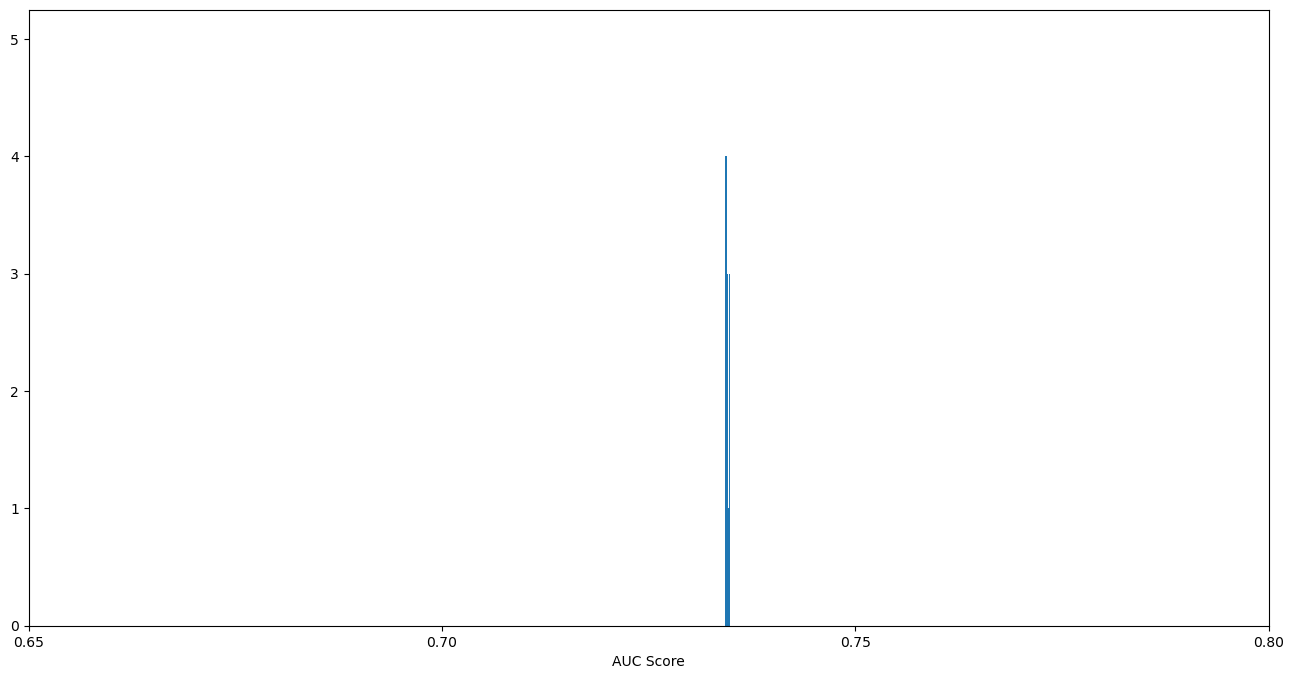

In [79]:
plt.figure(figsize=(16, 8))
plt.hist(auc_arr)
plt.xlabel("AUC Score")
plt.xticks(np.arange(0.65, 0.8, 0.05))
plt.savefig(os.path.join("/Users/rolex/Desktop/IGP/Project/plots/auc_sampling.png"))
plt.show()